### Generating Images with VAEs and GANs
- In this assignment, you will implement two models: a Variational Auto Encoder (VAE) and a Generative Adversarial Network (GAN), for the task of image generation. 
- You will train these models on Fashion-MNIST, a synthetic dataset including the grayscale images of shoes, clothes, hats, etc.
- For each task, we only provide abstract instructions.  You have the freedom to implement the model from scratch and customize helper functions for your convenience.
- We will primarily grade your work based on the quality of generated images by visualization.
- The GAN models usually need long-term training to produce high quality images. If you need GPUs to accelerate your experiment, please consider using Google's colab which provides free GPU runtime.




### Vartional Auto Encoder (VAE)
- A VAE is an image generation model following the design of an auto-encoder, consisting of an encoder and a decoder trained by minimizing the reconstruction error.  Unlike conventional Autoencoders, in which the bottleneck is constructed as reducing the capacity of the latent block, VAEs parameterize the latent space with a prior distribution, thereby providing a statistical interpretation of the reconstruction process. 
- A VAE model optimizes the Evidence Lower Bound (ELBO) as follows:
<center> $P(x) \geq E_{q_{\theta}(z|x)}[q_{\phi}(x|z)] + D_{KL}\left(q_{\theta}\left(z|x\right)|| p\left(z\right)\right)$ </center>
where $q_{\theta}, q_{\phi}$ are instantiated as encoder and decoder, respectively. $p(z)$ is the prior distribution, which is usually chosen as Normal distribution $\mathcal{N}(0,1)$
- After training VAE, you are expected to generate two diversified samples (function privided), which should hold similar content as the input.

In [3]:
"""
Import PyTorch libraries.
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random

In [4]:
"""
Enable CUDA if the GPU is available
"""
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Ankle Boot
9
torch.Size([1, 28, 28])


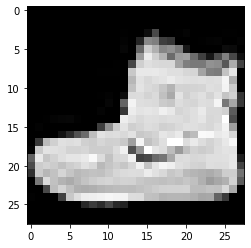

In [5]:
"""
Define the dataloader for the Fashion MNIST dataset.
"""
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()])) 
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(output_label(label))
print(label)
print(image.shape)

#### Define VAE Model (TODO) [20 points]
- Define encoder, decoder, and reparameterazation module 
- Implement the forward pass of the VAE model

In [6]:
"""
A Convolutional Variational Autoencoder
"""
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(784, 392)
        self.linear_down_m = nn.Linear(392, 20)
        self.linear_down_v = nn.Linear(392, 20)
        self.linear_up1 = nn.Linear(20, 392)
        self.linear_up2 = nn.Linear(392, 784)
        self.sigmoid_activation = nn.Sigmoid()

    def encode(self, x):
        x = F.relu(self.input_layer(x))
        mean = self.linear_down_m(x)
        logvar = self.linear_down_v(x)
        return mean, logvar
    
    def reparameterize(self, mean, var):
        logvar = var.exp()
        sample = torch.FloatTensor(mean.size()).normal_().to(device)
        out = sample.mul(logvar).add(mean)
        return out
    
    def decode(self, sample):
        x = F.relu(self.linear_up1(sample))
        out = self.sigmoid_activation(self.linear_up2(x))
        return out
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        sample = self.reparameterize(mean, logvar)
        decoded = self.decode(sample)
        return decoded, mean, logvar

#### Complete the Training Loop (TODO) [15 points]
- Implement the complete training loop for the VAE model

In [7]:
"""
Initialize Hyperparameters
"""
batch_size = 128
learning_rate = 1e-3
num_epochs = 20

"""
Initialize the network and the Adam optimizer
"""
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

"""
Training the network for a given number of epochs
"""
for epoch in range(num_epochs):
    model.train()
    train_loss1 = 0
    train_loss2 = 0
    for _, data in enumerate(train_loader):
        image, _ = data
        image = image.view(image.size(0), -1).to(device)
        optimizer.zero_grad()
        out, mean, logvar = model(image)
        image_loss = nn.MSELoss(reduction='sum')(out, image)
        kloss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        loss = image_loss + kloss
        loss.backward()
        optimizer.step()
        train_loss1 += image_loss
        train_loss2 += kloss
       
    print('Epoch {}/{}, loss {:.4f}'.format(epoch, num_epochs, (train_loss1+train_loss2)/ len(train_loader.dataset)))


Epoch 0/20, loss 35.6633
Epoch 1/20, loss 24.6583
Epoch 2/20, loss 22.6981
Epoch 3/20, loss 21.8235
Epoch 4/20, loss 21.3217
Epoch 5/20, loss 20.9933
Epoch 6/20, loss 20.7431
Epoch 7/20, loss 20.5362
Epoch 8/20, loss 20.3614
Epoch 9/20, loss 20.2149
Epoch 10/20, loss 20.1003
Epoch 11/20, loss 19.9962
Epoch 12/20, loss 19.9068
Epoch 13/20, loss 19.8332
Epoch 14/20, loss 19.7591
Epoch 15/20, loss 19.6899
Epoch 16/20, loss 19.6402
Epoch 17/20, loss 19.5820
Epoch 18/20, loss 19.5392
Epoch 19/20, loss 19.4910


#### Visualizing the output
- Display the VAE output by running multiple samples of the latent space.
- You can modify this function accordingly to fit your implementation

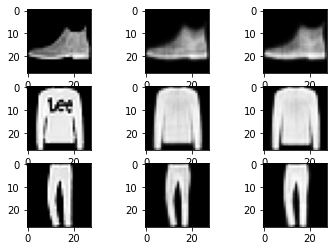

In [8]:

"""
The following part takes two images from test loader to feed into the VAE.
Both the original image and generated image(s) from the distribution are shown.
"""

import matplotlib.pyplot as plt
import numpy as np

model.eval()
with torch.no_grad():
    imgs, _ = list(test_loader)[0]
    imgs = imgs.to(device)
    new_img = imgs.view(imgs.size(0), -1)
    fig, ax = plt.subplots(3,3)
    ax = ax.reshape(-1)
    for i in range(3):
      for j in range(3):
        if j == 0:
          # input image
          img_i = np.transpose(imgs[i].cpu().numpy(), [1,2,0])
          ax[i*3+j].imshow(np.squeeze(img_i), cmap = 'gray')
        else:
          # vae generation results
          out, _, _ = model(new_img)
          out = out.cpu().numpy()[i].reshape(28,28)
          ax[i*3+j].imshow(out, cmap = 'gray')
    plt.show()


Generative Adversarial Network (GAN)
- A GAN is a generation model trained to convert the samples from prior distribution $z$ to the target domains $x$, e.g., images or text, in an unsupervised fashion.
- A GAN consists of a generator (G) and discriminator (D) model, where $G$ is trained to produce realistic samples of the target domain, while the $D$ learns to identified the samples from generator and the real domain, and serve as the supervision to optimize the $G$.
- GAN training typically follows two iterative steps:
  1. $\max_D \log\left(D\left(x\right)\right) + \log\left(1 - D\left(G\left(z\right)\right)\right)$
  2.$\max_G \log\left(D\left(G\left(z\right)\right)\right)$

#### Define GAN Model (TODO) [20 points]
- Define the generator and discriminator for the GAN model

In [13]:
start_size = 64
image_size = 784
int_size = 256
batch_size = 100

"""
Define the generator
"""
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.gen_seq = nn.Sequential(
            nn.Linear(start_size, int_size),
            nn.ReLU(),
            nn.Linear(int_size, int_size),
            nn.ReLU(),
            nn.Linear(int_size, image_size),
            nn.Tanh()
        )
    def forward(self, input):
        output = self.gen_seq(input)
        return output

"""
Define the discriminator 
"""
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()   
        self.disc_seq = nn.Sequential(
            nn.Linear(image_size, int_size),
            nn.LeakyReLU(0.2),
            nn.Linear(int_size, int_size),
            nn.LeakyReLU(0.2),
            nn.Linear(int_size, 1),
            nn.Sigmoid()  
        )

    def forward(self, input):
        output = self.disc_seq(input)
        return output

#### Complete the Training Loop (TODO) [15 points]
- Implement the complete training loop for the GAN model
- You can monitor the loss curve between generator and discriminator to tune the hyperparamters
- The loss of generator and discriminator converge toward some non-zero values at the end.  The generator's loss is generally higher than discriminator's loss.

In [47]:
"""
Initialize Hyperparameters
"""
learning_rate = 0.0002
num_epochs = 300
"""
Initialize the network and the Adam optimizer
"""
generator = Generator().to(device)
discriminator = Discriminator().to(device)
loss_func = nn.BCELoss()
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)

disc_losses = []
gen_losses = []
DofXs = []
GofDofXs = []

for epoch in range(num_epochs):
    for i, (images, label) in enumerate(train_loader):
        images = images.reshape(batch_size, -1).to(device)

        #discriminator
        rlabels = torch.ones(batch_size, 1).to(device)
        flabels = torch.zeros(batch_size, 1).to(device)
        out = discriminator(images)
        discriminator_rloss = loss_func(out, rlabels)
        DofX = out

        z = torch.randn(batch_size, start_size).to(device)
        fakes = generator(z)
        out = discriminator(fakes)
        discriminator_floss = loss_func(out, flabels)
        GofDofX = out

        discriminator_loss = discriminator_rloss + discriminator_floss

        disc_optimizer.zero_grad()
        gen_optimizer.zero_grad()
        discriminator_loss.backward()
        disc_optimizer.step()

        #generator
        z = torch.randn(batch_size, start_size).to(device)
        fakes = generator(z)
        zlabels = torch.ones(batch_size, 1).to(device)
        generator_loss = loss_func(discriminator(fakes), zlabels)

        disc_optimizer.zero_grad()
        gen_optimizer.zero_grad()
        generator_loss.backward()
        gen_optimizer.step()

        if (i+1) % len(train_loader) == 0:
            disc_losses.append(discriminator_loss.item())
            gen_losses.append(generator_loss.item())
            DofXs.append(DofX.mean().item())
            GofDofXs.append(GofDofX.mean().item())
            print('Epoch {}/{}, disc_loss: {:.4f}, gen_loss: {:.4f}, D(x): {:.4f}, D(G(x)): {:.4f}' 
                  .format(epoch, num_epochs, discriminator_loss.item(), generator_loss.item(), DofX.mean().item(), GofDofX.mean().item()))
      

Epoch 0/300, disc_loss: 0.2123, gen_loss: 4.9522, D(x): 0.8975, D(G(x)): 0.0874
Epoch 1/300, disc_loss: 0.2041, gen_loss: 3.8187, D(x): 0.9220, D(G(x)): 0.0619
Epoch 2/300, disc_loss: 0.1697, gen_loss: 5.8093, D(x): 0.9534, D(G(x)): 0.0855
Epoch 3/300, disc_loss: 0.2074, gen_loss: 4.2650, D(x): 0.9001, D(G(x)): 0.0309
Epoch 4/300, disc_loss: 0.3478, gen_loss: 4.2977, D(x): 0.8805, D(G(x)): 0.1147
Epoch 5/300, disc_loss: 0.4167, gen_loss: 3.2038, D(x): 0.8415, D(G(x)): 0.0601
Epoch 6/300, disc_loss: 0.5573, gen_loss: 4.1347, D(x): 0.7867, D(G(x)): 0.0832
Epoch 7/300, disc_loss: 0.3764, gen_loss: 4.2242, D(x): 0.8492, D(G(x)): 0.0421
Epoch 8/300, disc_loss: 0.3697, gen_loss: 3.3862, D(x): 0.8621, D(G(x)): 0.0992
Epoch 9/300, disc_loss: 0.4855, gen_loss: 4.6271, D(x): 0.8506, D(G(x)): 0.1123
Epoch 10/300, disc_loss: 0.5158, gen_loss: 3.2555, D(x): 0.7856, D(G(x)): 0.1120
Epoch 11/300, disc_loss: 0.4593, gen_loss: 3.0318, D(x): 0.8463, D(G(x)): 0.1242
Epoch 12/300, disc_loss: 0.3110, gen_l

#### Visualizing the output
- Display the GAN output by running multiple samples of the latent space.
- You can modify this function accordingly to fit your implementation

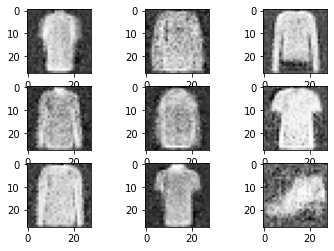

In [53]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3,3)
ax = ax.reshape(-1)
for i in range(9):
  z = torch.randn(1, latent_size).to(device)
  fake = generator(z)
  fake = fake.reshape((-1, 28,28)).squeeze(0).detach()
  ax[i].imshow(fake.cpu().data.numpy(), cmap = 'gray')
plt.show()